# DATA 643: Recommender Systems
Final Project:  Book Crossing RecSys | Walt Wells, Summer 2017

# Notebook P3 - Model | Factorization

# Environment Prep

In [1]:
suppressMessages(library(Matrix))
suppressMessages(library(recommenderlab))
suppressMessages(library(ggplot2))
suppressMessages(library(rARPACK))
suppressMessages(library(reshape2))
source('helper.R')

# Data Prep

In [34]:
BinBook <- readRDS("binBookM.rds")
Book <- readRDS("BookM.rds")

In [3]:
SparseM <- as(Book, "dgCMatrix")
SparseMBin <- as(BinBook, "dgCMatrix")

# SVD

Since we are dealing with large and sparse matrices, we will use the Truncated SVD method available in the rARPACK library. 

## Helper:  Variability Table

In [4]:
SVDRemoveTable <- function(s) {
    df <- data.frame()
    for (i in seq(nrow(s))) {
        m <- sum(s[1:i, 1:i]^2)/sum(s^2)
        df <- rbind(df, c(i, m))
    }
    names(df) <- c("concepts", "variability")
    df
}

## Sample:   Test SVDs 

In [5]:
k <- 25
x <- svds(SparseM, k)

In [6]:
str(x)
SMat <- diag(x$d)
U <- x$u
V <- x$v

List of 5
 $ d    : num [1:25] 55.9 49.7 40.7 39.3 38.7 ...
 $ u    : num [1:33095, 1:25] 2.99e-09 -4.79e-19 3.06e-19 -2.99e-20 1.88e-09 ...
 $ v    : num [1:95795, 1:25] 1.01e-08 8.12e-11 -6.64e-15 0.00 5.97e-09 ...
 $ niter: int 6
 $ nops : int 269


### Review relationship between k and variability

In [7]:
mytable <- SVDRemoveTable(SMat)

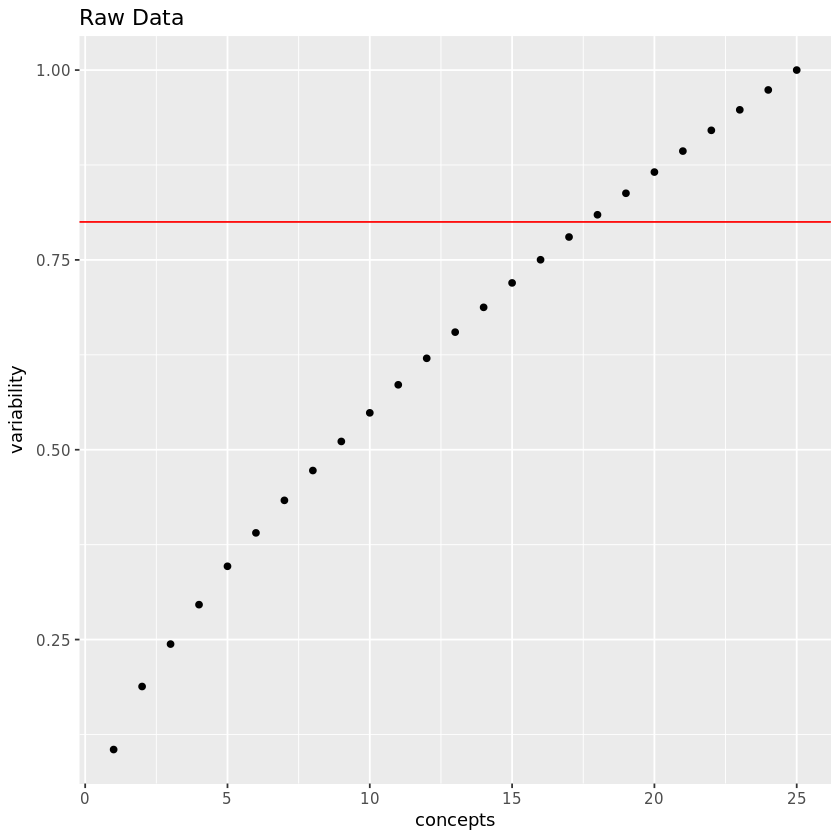

In [9]:
ggplot(mytable, aes(concepts, variability)) + geom_point() + 
    geom_hline(yintercept = .80, color='red') + 
    ggtitle("Sample SVDs")

### Factorized Matrix

In [10]:
n <- .8 * k

NewSMat <- SMat[1:n, 1:n]
NewU <- U[,1:n]
NewV <- V[,1:n]

PreComputed <- NewSMat %*% t(NewV)

In [11]:
getSizeDim(SparseM)
getSizeDim(NewSMat)
getSizeDim(NewU)
getSizeDim(NewV)
getSizeDim(PreComputed)

[1] "Object SparseM size: 20.905 MB |  Dim: 33095 95795"
[1] "Object NewSMat size: 0.003 MB |  Dim: 20 20"
[1] "Object NewU size: 5.05 MB |  Dim: 33095 20"
[1] "Object NewV size: 14.617 MB |  Dim: 95795 20"
[1] "Object PreComputed size: 14.617 MB |  Dim: 20 95795"


### Make Sample Prediction

In [12]:
r_bar <- colMeans(Book)
samp <- sample(nrow(NewU),1)
q <- NewU[samp,]
#SampleUserActual <- Book[samp,]

In [13]:
qV <- q %*% PreComputed

In [14]:
ItemIndex <- SparseM@Dimnames[2]
qV <- data.frame(ItemIndex, t(qV))
colnames(qV) <- c("ISBN", "Prediction")

In [15]:
n <- 10
sorted_qV <- qV[order(-qV$Prediction), ]
head(sorted_qV, n)

,ISBN,Prediction
30737,0441005667,8.424973e-17
40351,0553250426,8.300465e-17
13351,031298328X,8.075878e-17
11840,0312195516,7.948854e-17
27165,0415900522,7.423004e-17
47607,0671697994,7.293665e-17
30648,0441000916,7.044046e-17
15849,0345333926,6.902415e-17
4182,0064400557,6.465730e-17
40469,0553258524,6.426474e-17


In [16]:
#saveRDS(PreComputed, "SVDOutput.rds")

# Evaluation

## Get RMSE by Reducing Matrix Size

I couldn't find a good way to evalute these that wasn't too memory intensive.   As a result, we'll predict instead over a subset of books and users, and calculate the RMSE from a more manageable subset.  After going through the simple exercise of calculating RMSE based on a single sample, we will take multiple samples, calculate the RMSE for each, and choose the best methods.  

In [17]:
N <- 5000
startV <- sample(1:nrow(SparseM), 50)
startU <- sample(1:ncol(SparseM), 50)
SubU <- NewU[1:N,]
SubV <- NewV[1:N,]
PredSamp <- SubU %*% NewSMat %*% t(SubV)
getSizeDim(PredSamp)

[1] "Object PredSamp size: 190.735 MB |  Dim: 5000 5000"


In [18]:
KnownSamp <- as(Book[1:N, 1:N], 'matrix')
getSizeDim(KnownSamp)

[1] "Object KnownSamp size: 191.307 MB |  Dim: 5000 5000"


In [19]:
PredSamp[is.na(KnownSamp)] <- NA

In [20]:
RMSE <- function(observed, predicted) {
    # get RMSE
    sqrt(mean((observed - predicted)^2, na.rm=TRUE))
}

In [21]:
RMSE(KnownSamp, PredSamp)

[1] 1.357277

## Helper Functions

In [22]:
GetSVDsRMSE <- function(N_subset, N_sims, SparseMatrix, k, keepVar) {
    # Computes a list of RMSE values of the Truncated SVD to help tuning.  
    # Uses sampling because difficult to manage calc of full RMSE
    #
    # Args:
    #   N_subset:  size of final sampled | predicted matrix (sample will be square for ease)
    #   N_sims:  number of times to sample and calc RMSE based on calculated SVD
    #   SparseMatrix: Matrix to factorize
    #   k:  number of features to use in svds calculation
    #   keepVar: percent of the singular values to retain
    #
    # Returns:
    #   A list of RMSE for each sample taken
    
    mylist <- list()
    
    # calculate truncated svd
    x <- svds(SparseMatrix, k)
    SMat <- diag(x$d)
    U <- x$u
    V <- x$v

    # reduction
    n <- keepVar * k
    NewSMat <- SMat[1:n, 1:n]
    NewU <- U[,1:n]
    NewV <- V[,1:n]
    
    for (i in 1:N_sims) {
        # sample to calc RMSE
        startV <- sample(1:nrow(SparseMatrix), N_subset)
        startU <- sample(1:ncol(SparseMatrix), N_subset)
        
        # create new mat
        SubU <- NewU[startV,]
        SubV <- NewV[startU,]
        PredSamp <- SubU %*% NewSMat %*% t(SubV)
        KnownSamp <- as(Book[startV, startU], 'matrix')

        # only calc RMSE for actual observed
        PredSamp[is.na(KnownSamp)] <- NA

        rmse <- RMSE(KnownSamp, PredSamp)
        mylist[[i]] <- rmse
    }
    mylist
}

In [23]:
simMeans <- function(simresults, N_sims, klist) {
    # takes results from GetSVDsRMSE, returns a named list of means for each k simulated
    testfull <- matrix(as.numeric(simresults), N_sims, length(klist))
    meansByK <- colMeans(testfull)
    names(meansByK) <- klist
    meansByK
}

## Test Function

In [24]:
test <- GetSVDsRMSE(5000, 2, SparseM, 25, .8)
test

[[1]]
[1] 1.262673

[[2]]
[1] 1.441457

## Start Timer

In [ ]:
ptm <- proc.time()

## Run Simulations

In [25]:
klist <- c(3,seq(5, 30, by=5), seq(40, 100, by=10))
N_sims <- 10
N_subset <- 10000

In [27]:
EX_70SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseM, 
                    keepVar = .70)

In [26]:
EX_80SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseM, 
                    keepVar = .8)

In [28]:
EX_90SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseM, 
                    keepVar = .90)

In [28]:
IM_70SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseMBin, 
                    keepVar = .70)

In [28]:
IM_80SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseMBin, 
                    keepVar = .80)

In [28]:
IM_90SVD <- sapply(klist,
                    GetSVDsRMSE,
                    N_subset = N_subset, 
                    N_sims = N_sims,
                    SparseMatrix = SparseMBin, 
                    keepVar = .90)

In [46]:
simresults <- data.frame(k = klist,
                        Ex_Var70 = simMeans(EX_70SVD, N_sims, klist),
                        Ex_Var80 = simMeans(EX_80SVD, N_sims, klist), 
                        Ex_Var90 = simMeans(EX_90SVD, N_sims, klist),
                        Im_Var70 = simMeans(Im_70SVD, N_sims, klist),
                        Im_Var80 = simMeans(Im_80SVD, N_sims, klist), 
                        Im_Var90 = simMeans(Im_90SVD, N_sims, klist))
head(simresults)

,k,SVD_Var80,SVD_Var85,SVD_Var90
3,3,1.399157,1.397059,1.369466
5,5,1.374675,1.388618,1.401326
10,10,1.404001,1.394609,1.375379
15,15,1.372384,1.380022,1.374116
20,20,1.359805,1.361218,1.373223
25,25,1.334047,1.349118,1.353315


In [48]:
longSim <- melt(simresults, id="k")

## Plot Results

`geom_smooth()` using method = 'loess'


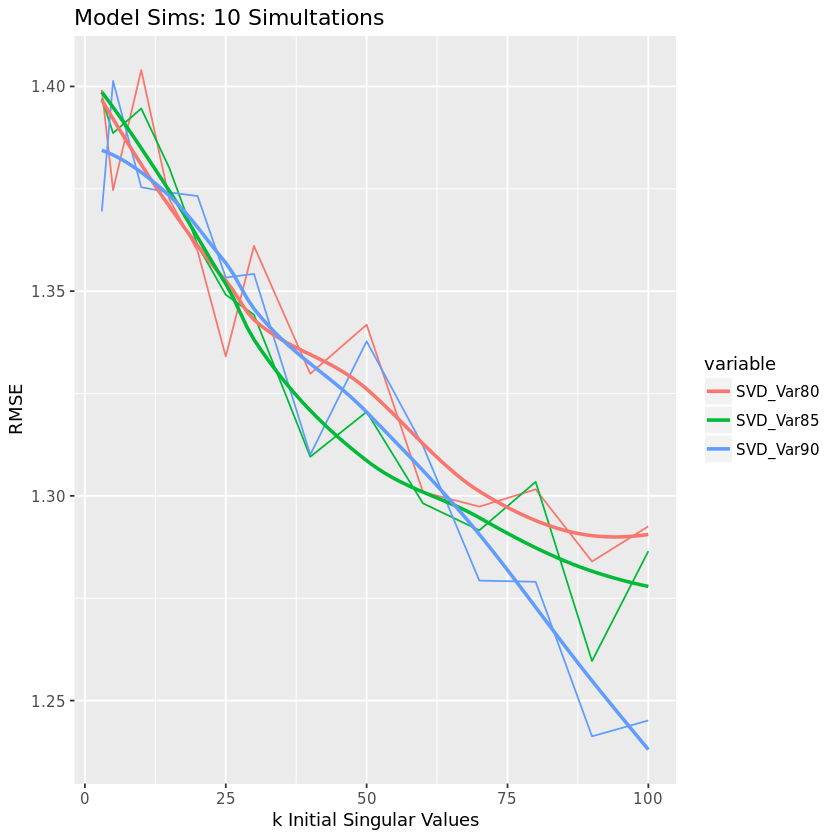

In [49]:
plottext <- paste0("Model Sims: ", N_sims, " Simultations") 
ggplot(longSim, aes(x=k, y=value, colour=variable)) + geom_line() + geom_smooth(se=F) + 
    ylab("RMSE") + xlab("k Initial Singular Values") + 
    ggtitle(plottext)

## Stop Timer

In [ ]:
finaltime <- proc.time() - ptm
finaltime